# Explore Orbits and Noises of Space Detectors

Orbits and noises are two sets of important properties of space detectors, here we give examples of how they are calculated and show how to plot the diagrams in our paper.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from gwspace.Waveform import waveforms
from gwspace.Orbit import TianQinOrbit
from gwspace.Orbit import get_pos
from gwspace.Noise import TianQinNoise, LISANoise, TaijiNoise
from gwspace.constants import DAY, YRSID_SI, MONTH

Like waveforms, each kind of orbits and noises has its own class. These classes can be called either directly or through the dictionary:

In [2]:
from gwspace.Noise import detector_noises
from gwspace.Orbit import detectors

print('Support detector noises:', detector_noises.keys())
print('Support detector orbits:', detectors.keys())
# You will notice TianQin have two aliases: TianQin and TQ

Support detector noises: dict_keys(['TQ', 'LISA', 'Taiji', 'TianQin'])
Support detector orbits: dict_keys(['TQ', 'LISA', 'Taiji', 'TianQin'])


## Orbit

By giving a series of time to orbit classes, you can get a class entity with positions(x, y, z) of three spacecrafts.

Alternatively, we also implement orbit calculation using C(Cython), which is mainly for FastGB, but you can still use it individually:

Time cost for initial position: 2.193596124649048 s
Time cost for initial position(Cython): 1.8733329772949219 s


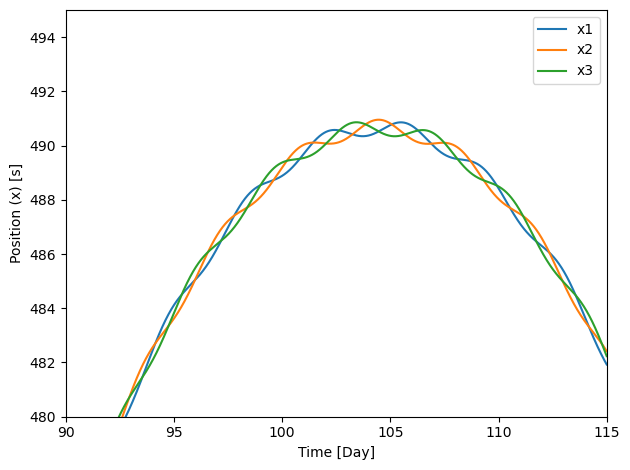

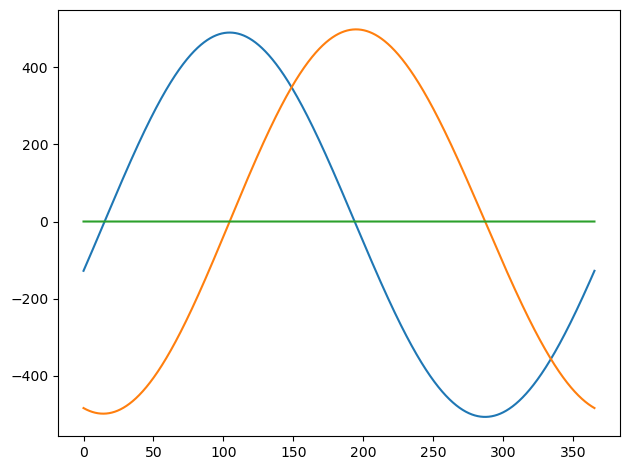

In [3]:
T_obs = YRSID_SI
delta_t = 10
tf = np.arange(0, T_obs, delta_t)

st = time.time()
TQOrbit = TianQinOrbit(tf)
ed = time.time()
print(f"Time cost for initial position: {ed-st} s")

st = time.time()
x, y, z, L = get_pos(tf, detector="TianQin")
ed = time.time()
print(f"Time cost for initial position(Cython): {ed-st} s")

tf_d = tf/DAY
# Now let's check the orbits
plt.figure()
plt.plot(tf_d, TQOrbit.orbits[0][0], label='x1')
plt.plot(tf_d, TQOrbit.orbits[1][0], label='x2')
plt.plot(tf_d, TQOrbit.orbits[2][0], label='x3')
plt.xlabel('Time [Day]')
plt.ylabel('Position (x) [s]')
# Zoom in to see the details
plt.xlim(90, 115)
plt.ylim(480, 495)
plt.legend()
plt.tight_layout()

# Check how constellation center moves (For TianQin, that is how Earth moves)
plt.figure()
for i in range(3):
    plt.plot(tf_d, TQOrbit.p_0[i])
plt.tight_layout()

# plt.figure()
# plt.plot(tf_d, x[0], label="x1")
# plt.plot(tf_d, x[1], label="x2")
# plt.plot(tf_d, x[2], label="x3")
# plt.xlabel('Time [Day]')
# plt.ylabel('Position (x) [s]')
# plt.xlim(90, 115)
# plt.ylim(480, 495)
# plt.legend()
# plt.tight_layout()

Take orbit calculation in FastGB lib as an example, now we can investigate the relative angle between different detectors:

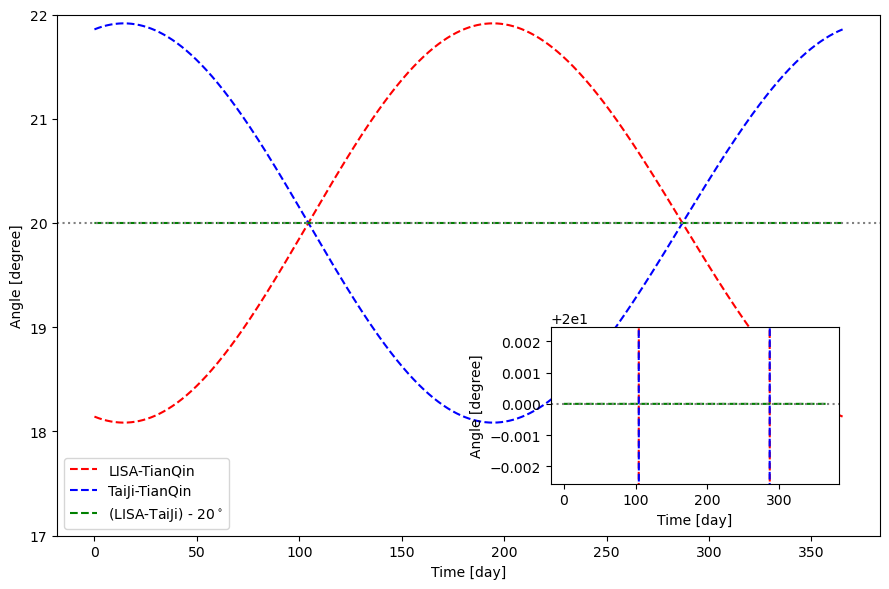

In [4]:
dt = 3600
tf = np.arange(0, YRSID_SI, dt)

xt_l, yt_l, zt_l, L_l = get_pos(tf, detector="LISA")
xt_tj, yt_tj, zt_tj, L_tj = get_pos(tf, detector="TaiJi")
xt_tq, yt_tq, zt_tq, L_tq = get_pos(tf, detector="TianQin")


def get_centre(x, y, z):
    return np.array([x[0]+x[1]+x[2], y[0]+y[1]+y[2], z[0]+z[1]+z[2]])/3


def get_theta(a, b):
    
    def get_norm(p):
        return np.sqrt(p[0]**2+p[1]**2+p[2]**2)
    
    Ra = get_norm(a)
    Rb = get_norm(b)
    costheta = (a[0]*b[0]+a[1]*b[1]+a[2]*b[2])/Ra/Rb
    theta = np.arccos(costheta)
    return theta


pos_l = get_centre(xt_l, yt_l, zt_l)
pos_tj = get_centre(xt_tj, yt_tj, zt_tj)
pos_tq = get_centre(xt_tq, yt_tq, zt_tq)

theta_ltj = get_theta(pos_l, pos_tj)
theta_ltq = get_theta(pos_l, pos_tq)
theta_tjtq = get_theta(pos_tj, pos_tq)

tf_d = tf/DAY
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(tf_d, theta_ltq/np.pi*180, '--r', label="LISA-TianQin")
ax.plot(tf_d, theta_tjtq/np.pi*180, '--b', label="TaiJi-TianQin")
ax.plot(tf_d, theta_ltj/np.pi*180-20, '--g', label=r"(LISA-TaiJi) - 20$^\circ$")

ax.axhline(20, color='gray', ls=':')
ax.set_ylim(17, 22)
ax.set_xlabel("Time [day]")
ax.set_ylabel("Angle [degree]")

axins = ax.inset_axes((0.6, 0.1, 0.35, 0.3))
axins.plot(tf_d, theta_ltq/np.pi*180, '--r')
axins.plot(tf_d, theta_tjtq/np.pi*180, '--b')
axins.plot(tf_d, theta_ltj/np.pi*180-20, '--g')

axins.axhline(20, color='gray', ls=':')
axins.set_ylim(20-2.55e-3, 20+2.45e-3)
axins.set_xlabel("Time [day]")
axins.set_ylabel("Angle [degree]")

ax.legend(loc='best')
plt.tight_layout()

## Noise

One thing that needs to be noticed for detector noises is that LISA has an additional confusion noise correction, which is determined by observation time.

Now let's take an overview:

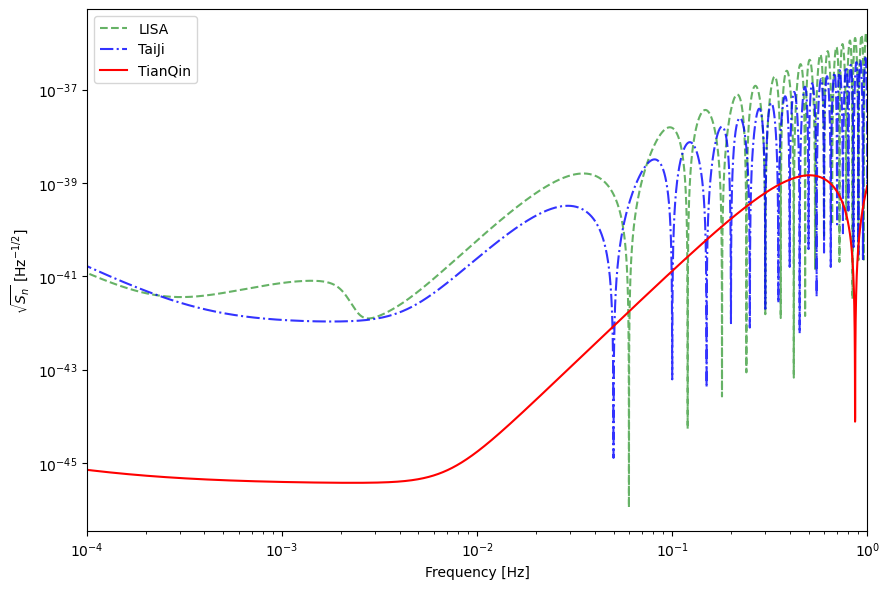

In [5]:
tq_noise = TianQinNoise()
lisa_noise = LISANoise()
taiji_noise = TaijiNoise()
freq = np.logspace(-5, 0, 10000)

TQ_A, _ = tq_noise.noise_AET(freq)
LISA_A, _ = lisa_noise.noise_AET(freq, wd_foreground=3*MONTH/YRSID_SI)
LISA_A_4yr, _ = lisa_noise.noise_AET(freq, wd_foreground=4)
Taiji_A, _ = taiji_noise.noise_AET(freq)

plt.figure(figsize=(9,6))
plt.loglog(freq, LISA_A_4yr, 'g--', alpha=0.6, label="LISA")
plt.loglog(freq, Taiji_A, 'b-.', alpha=0.8, label="TaiJi")
plt.loglog(freq, TQ_A, 'r-', label="TianQin")
plt.xlim(1e-4,1)
plt.xlabel("Frequency [Hz]")
plt.ylabel('$\\sqrt{S_n}$ [Hz$^{-1/2}$]')
plt.legend()
plt.tight_layout()

## Example data-set

### Massive BBHs

In [6]:
MBHBpars = {"mass1": 3.5e6,
            "mass2": 2.1e5,
            'T_obs': MONTH*3,
            "chi1": 0.2,
            "chi2": 0.1,
            "DL": 1e3,
            "psi": 0.2,
            "iota": 0.3,
            "Lambda": 0.4,
            "Beta": 1.2,
            "tc": 0,
            }

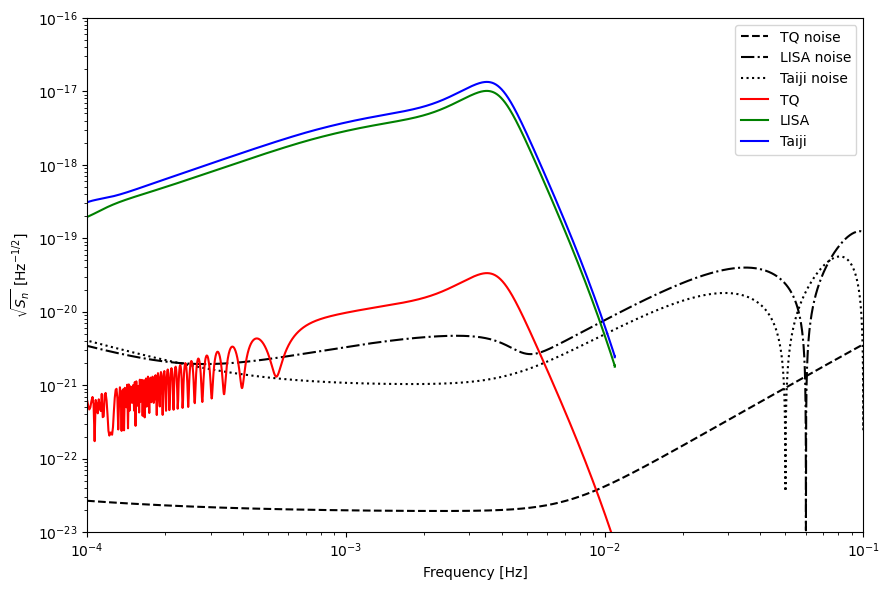

In [7]:
BHBwf = waveforms['bhb_PhenomD'](**MBHBpars)
delta_f = 1e-6  # 1/BHBwf.T_obs
freq_h = np.arange(np.ceil(BHBwf.f_min/delta_f)*delta_f, 1., delta_f)

MBBH_A = {}
for d in ['TQ', 'LISA', 'Taiji']:
    MBBH_A[d], _, _ = BHBwf.get_tdi_response(freq_h, det=d)

plt.figure(figsize=(9, 6))
plt.loglog(freq, np.sqrt(TQ_A), 'k--', label='TQ noise')
plt.loglog(freq, np.sqrt(LISA_A), 'k-.', label='LISA noise')
plt.loglog(freq, np.sqrt(Taiji_A), 'k:', label='Taiji noise')

# Determine where the waveform is zero
i_max = np.where(MBBH_A['TQ'] == 0)[0][0]
plt.loglog(freq_h[:i_max], np.abs(MBBH_A['TQ'][:i_max])*np.sqrt(freq_h[:i_max]), 'r-', label='TQ')
plt.loglog(freq_h[:i_max], np.abs(MBBH_A['LISA'][:i_max])*np.sqrt(freq_h[:i_max]), 'g-', label='LISA')
plt.loglog(freq_h[:i_max], np.abs(MBBH_A['Taiji'][:i_max])*np.sqrt(freq_h[:i_max]), 'b-', label='Taiji')

plt.xlabel('Frequency [Hz]')
plt.ylabel('$\\sqrt{S_n}$ [Hz$^{-1/2}$]')
plt.xlim(1e-4, 1e-1)
plt.ylim(1e-23, 1e-16)
plt.legend()
plt.tight_layout()

### Stellar-mass BBHs

In [8]:
smBBHpars = {'DL': 100,  # Luminosity distance (Mpc)
             'mass1': 35.6,  # Primary mass (solar mass)
             'mass2': 30.6,  # Secondary mass(solar mass)
             'Lambda': 4.7,  # Longitude
             'Beta': -1.5,  # Latitude
             'phi_c': 0,  # Coalescence phase
             'T_obs': MONTH*3,  # Observation time (s)
             'tc': 0,  # Coalescence time (s)
             'iota': 0.3,  # Inclination angle
             'var_phi': 0,  # Observer phase
             'psi': 0.2,  # Polarization angle
             }  # masses of GW150914

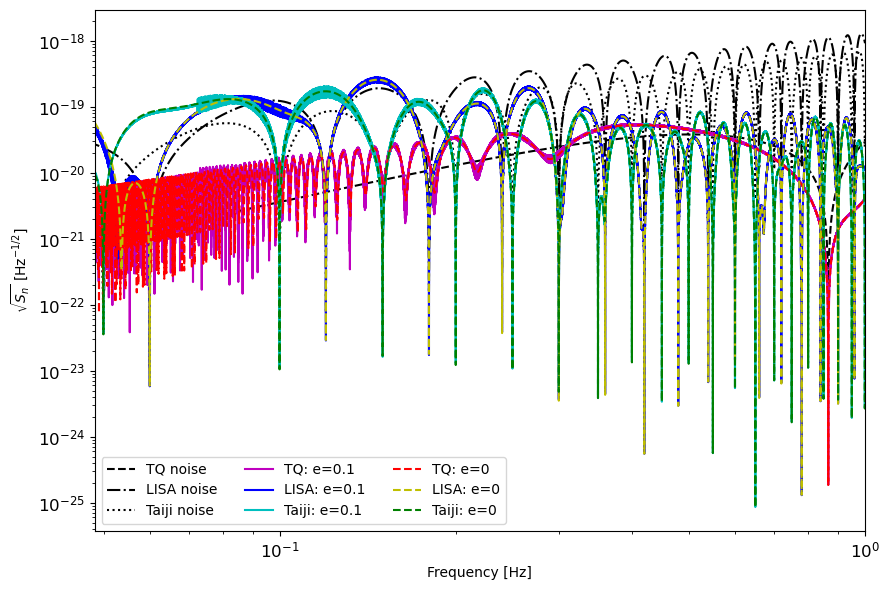

In [9]:
BHBwf = waveforms['bhb_PhenomD'](**smBBHpars)
ecc_wf = waveforms['bhb_EccFD'](**smBBHpars, eccentricity=0.1)
delta_f = 1e-5  # 1/BHBwf.T_obs
freq_e0 = np.arange(np.ceil(BHBwf.f_min/delta_f)*delta_f, 1., delta_f)

smBBH_A_e0, smBBH_A_e1 = {}, {}
for d in ['TQ', 'LISA', 'Taiji']:
    smBBH_A_e0[d], _, _ = BHBwf.get_tdi_response(freq_e0, det=d)
    (smBBH_A_e1[d], _, _), freq_e1 = ecc_wf.get_tdi_response(det=d, delta_f=delta_f)

plt.figure(figsize=(9, 6))
plt.loglog(freq, np.sqrt(TQ_A), 'k--', label='TQ noise')
plt.loglog(freq, np.sqrt(LISA_A), 'k-.', label='LISA noise')
plt.loglog(freq, np.sqrt(Taiji_A), 'k:', label='Taiji noise')

plt.loglog(freq_e1, np.abs(smBBH_A_e1['TQ'])*np.sqrt(freq_e1), 'm-', label='TQ: e=0.1')
plt.loglog(freq_e1, np.abs(smBBH_A_e1['LISA'])*np.sqrt(freq_e1), 'b-', label='LISA: e=0.1')
plt.loglog(freq_e1, np.abs(smBBH_A_e1['Taiji'])*np.sqrt(freq_e1), 'c-', label='Taiji: e=0.1')
    
plt.loglog(freq_e0, np.abs(smBBH_A_e0['TQ'])*np.sqrt(freq_e0), 'r--', label='TQ: e=0')
plt.loglog(freq_e0, np.abs(smBBH_A_e0['LISA'])*np.sqrt(freq_e0), 'y--', label='LISA: e=0')
plt.loglog(freq_e0, np.abs(smBBH_A_e0['Taiji'])*np.sqrt(freq_e0), 'g--', label='Taiji: e=0')
    
plt.xlabel('Frequency [Hz]')
plt.ylabel('$\\sqrt{S_n}$ [Hz$^{-1/2}$]')
plt.tick_params(labelsize=12)
plt.xlim(BHBwf.f_min, 1)
plt.legend(ncols=3)
plt.tight_layout()